<a href="https://colab.research.google.com/github/marjanaziminezhad/structural_bioinformatics/blob/main/ex03/ex03_MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 03

## Aim of the exercise:

We will learn to:

- use OpenMM to simulate a protein in water
- understand the steps for setting up a simulation

This exercise is based on the official tutorials of [OpenMM](https://github.com/openmm/openmm_workshop_july2023) and [MDAnalysis](https://userguide.mdanalysis.org/stable/examples/quickstart.html).

<img src="https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex03/openmm_logo.png?raw=1" width="50"/>

# OpenMM

OpenMM is a versatile and high-performance toolkit designed for molecular simulation. It stands out due to its unique blend of features, which include extreme flexibility, openness, and exceptional performance, particularly on modern GPUs.

Summary of Contents:
1. **Setup Conda Environment**: Instructions on preparing the necessary computational environment using Conda.
2. **Download Protein File**: Steps to obtain the required protein structure file.
3. **Load a PDB File into OpenMM**: Tutorial on how to import and use a PDB file within OpenMM.
4. **Choose the Force-Field**: Guidance on selecting appropriate force-fields for the simulation.
5. **Solvate the Protein with Water and Ions**: Process of adding water and ions to the protein environment.
6. **Setup System and Integrator**: Instructions on initializing the simulation system and integrator.
7. **Run Local Minimization**: Steps for performing local energy minimization of the system.
8. **Setup Reporting**: How to configure reporting tools for monitoring simulation progress.
9. **Run NVT Equilibration**: Conducting NVT (constant Number, Volume, Temperature) equilibration simulations.
10. **Run NPT Production Molecular Dynamics**: Executing NPT (constant Number, Pressure, Temperature) production simulations.
11. **Basic Analysis**: Introduction to fundamental analysis techniques for simulation data.
12. **How to Use Checkpoints**: Instructions on setting up and utilizing checkpoints for long-term simulations.
13. **Visualization**: Tips and tools for visualizing the simulation results.



## Setup
**First try and change runtime type to GPU!**  
Click "runtime">"change runtime type" and select "GPU" from the "Hardware accelerator" dropdown menu.
CPU works, but it is slower.


In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  !pip install -q condacolab
  import condacolab
  condacolab.install_mambaforge()
  !mamba install -y -c conda-forge openmm

else:
  print('Not running on colab.')
  print('Make sure you create and activate a new conda environment!')

Running on colab
✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['openmm']

conda-forge/linux-64                          

**Note:** During this step on Colab the kernel will be restarted. This will produce the error message:
"Your session crashed for an unknown reason. " This is normal and you can safely ignore it.

**Note:** Installing the packages will take several minutes!

In [ ]:
# check the installation
!python -m openmm.testInstallation


OpenMM Version: 8.1
Git Revision: 43f571d90fc1c882848cbd9b55e097a1775a9075

There are 3 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 CUDA - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.29968e-06
Reference vs. CUDA: 6.73338e-06
CPU vs. CUDA: 7.37096e-07

All differences are within tolerance.


## Protein to Study: Villin headpiece


Villin is a popular protein for molecular dynamics studies, and several papers on its folding have been published. Additionally, it has been found that the proximity of three phenylalanines that comprise the hydrophobic core is important for the correct structure.

This is small fast folding protein commonly used as a toy system. Note that this PDB file has been cleaned up and is ready for use in OpenMM. If you try and use a PDB file directly from the protein data bank you may encounter errors. Please look at the [OpenMM FAQs](https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions) and [PDBfixer](https://github.com/openmm/pdbfixer).

![villin](https://github.com/yerkoescalona/structural_bioinformatics/blob/main/ex03/villin.png?raw=1)
**Figure**. Villin headpiece protein.


In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  !wget https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex03/villin.pdb
else:
  print('Not running on colab.')
  print('You should have villin.pdb in your path!')

Running on colab
--2023-11-30 09:59:57--  https://raw.githubusercontent.com/yerkoescalona/structural_bioinformatics/main/ex03/villin.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39178 (38K) [text/plain]
Saving to: ‘villin.pdb.2’

villin.pdb.2        100%[===================>]  38.26K  --.-KB/s    in 0.01s   

2023-11-30 09:59:57 (3.34 MB/s) - ‘villin.pdb.2’ saved [39178/39178]



## Load the PDB file into OpenMM
<a id="load"></a>

First we need to import OpenMM.
We then then load in the PDB file using the [PDBFile](http://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html#openmm.app.pdbfile.PDBFile) class.

In [ ]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

# load in the pdb file
pdb = PDBFile('villin.pdb')

`PDBFile('file_name.pdb')` loads the PDB file from disk and puts the information into a `PDBFile` object which we have assign to the variable `pdb`. The object contains the molecular topology (atom names, residue types, bonds etc) and the atomic positions. These can be accessed as `pdb.topology` and `pdb.positions`. Take a look at the [API documentation](http://docs.openmm.org/latest/api-python/generated/openmm.app.pdbfile.PDBFile.html#openmm.app.pdbfile.PDBFile). All OpenMM classes have documentation available on the Python API reference: http://docs.openmm.org/latest/api-python/.

## Define the force field
<a id="ff"></a>

We need to define the forcefield we want to use. We will use the Amber14 forcefield and the TIP3P-FB water model. You can find out about all the forcefields available by default in OpenMM in the [documentation](http://docs.openmm.org/latest/userguide/application/02_running_sims.html?highlight=forcefield#force-fields).

In [ ]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

Force fields are defined by XML files. The line above loads in specified files. You can look at them in the OpenMM source code, e.g. [`amber14/tip3pfb.xml`](https://github.com/openmm/openmm/blob/master/wrappers/python/openmm/app/data/amber14/tip3pfb.xml). It is possible to create your own XML force field file. You can find details in the [user guide](http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#creating-force-fields).

## Solvate
<a id="solvate"></a>

We can use the [`Modeller`](http://docs.openmm.org/latest/userguide/application/03_model_building_editing.html#model-building-and-editing) class to solvate the protein in a waterbox.

In [ ]:
# create a Modeller object
modeller = Modeller(pdb.topology, pdb.positions)


# Solvate the protein in a box of water
modeller.addExtraParticles(forcefield)

This command creates a box that has edges at least 1nm away from the solute and fills it with water molecules. Additionally, it adds in the required number of CL- and Na+ ions to make the system charge neutral. Optionally, you can specify the ion concentration as an argument to [`addSolvent`](http://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html#openmm.app.modeller.Modeller.addSolvent).

Note that the `nanometer` variable is a unit definition that was imported from `openmm.unit`. This is an example of the powerful units tracking and automatic conversion facility built into the OpenMM Python API that makes specifying unit-bearing quantities convenient and less error-prone. We could have equivalently specified `10*angstrom` instead of `1*nanometer` and achieved the same result. You can read more about the units library [here](http://docs.openmm.org/latest/userguide/library/05_languages_not_cpp.html#units-and-dimensional-analysis).


## Setup system and Integrator
<a id='system'></a>

We now need to combine our molecular topology and the forcefield to create a complete description of the system. This is done using the [`ForceField`](http://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#forcefield) object’s [`createSystem()`](http://docs.openmm.org/latest/api-python/generated/openmm.app.forcefield.ForceField.html#openmm.app.forcefield.ForceField.createSystem) method. We then create the integrator, and combine the integrator and system to create the Simulation object. Finally we set the initial atomic positions.

In [ ]:
# Create a system. Here we define some forcefield settings such as the nonbonded method
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)

# Define the integrator. The Langevin integrator is also a thermostat
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

The [System](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.System.html#system) is an object than contains the complete mathematical description of the system we want to simulate. It contains four key bits of information:
 - The set of particles in the simulation
 - The forces acting on them
 - Details of any constraints
 - The dimensions of the periodic box

The `integrator` advances the equations of motion. There are a variety of [integrators available in OpenMM](http://docs.openmm.org/latest/api-python/library.html#integrators). We are using the [LangevinMiddleIntegrator](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html#openmm.openmm.LangevinMiddleIntegrator) which performs Langevin dynamics.

The [`Simulation`](http://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation) object manages all the process involved in running a simulation, such as advancing time and writing output.


## Local energy minimization
<a id="minim"></a>

It is a good idea to run local energy minimization at the start of a simulation because the coordinates in starting configuration file might produce very large forces.

Due to how the minimizer is implemented it will not print out information during the run. You will need to be patient and wait for it to complete. This minimization step should take ~1 minute on CPU and a few seconds on GPU.

In [ ]:
print("Minimizing energy")
simulation.minimizeEnergy()

Minimizing energy


## Setup reporting
<a id="reporting"></a>

To get output from a simulation you need to add "reporters". We use [`DCDReporter`](http://docs.openmm.org/latest/api-python/generated/openmm.app.dcdreporter.DCDReporter.html) to write the coordinates every 1000 timesteps to 'traj.dcd' and we use [`StateDataReporter`](http://docs.openmm.org/development/api-python/generated/openmm.app.statedatareporter.StateDataReporter.html) to print the timestep, potential energy, temperature, and volume to the screen; and the same to a file called 'md_log.txt'. The Simulation object contains a list of reporters in `simulation.reporters` and we use the append method to add the reporters to it.

In [ ]:
# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))


## NVT equilibration
<a id=nvt></a>

We are using a Langevin integrator which means we are simulating in the NVT ensemble. To equilibrate the temperature we just need to run the simulation for a number of timesteps.

In [ ]:
print('Running NVT')
simulation.step(10000)

Running NVT
#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)"
1000,-2033.4586990804564,288.2202246777153,87.86585834570701
2000,-2005.8232528896224,309.93401441879934,87.86585834570701
3000,-2027.7626208991896,322.09675354084845,87.86585834570701
4000,-1996.5671164722335,311.3546662728655,87.86585834570701
5000,-2189.489236566533,293.83493350185574,87.86585834570701
6000,-2055.599782201756,292.6530877496886,87.86585834570701
7000,-2089.7403847904097,293.01749284643813,87.86585834570701
8000,-2017.445629808415,320.5262886061663,87.86585834570701
9000,-2102.305453512181,295.1812975505081,87.86585834570701
10000,-2078.7425148219954,315.3639669904465,87.86585834570701


## NPT production MD
<a id=npt></a>

To run our simulation in the NPT ensemble we need to add in a barostat to control the pressure. We can use [`MonteCarloBarostat`](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.MonteCarloBarostat.html#openmm.openmm.MonteCarloBarostat). The parameters are the pressure (1 bar) and the temperature (300 K). The barostat assumes the simulation is being run at constant temperature, but it does not itself do anything to regulate the temperature. It is therefore critical that you always use it along with a Langevin integrator or Andersen thermostat, and that you specify the same temperature for both the barostat and the integrator or thermostat. Otherwise, you will get incorrect results.

In [ ]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

# It is important to call the reinitialize method on the simulation
# otherwise the modifications will not be applied.
simulation.context.reinitialize(preserveState=True)

We then run the simulation for 10000 steps.

In [ ]:
print('Running NPT')
simulation.step(10000)

Running NPT
11000,-2203.331520416894,281.5486718110163,82.0255023224423
12000,-2023.5230277344235,277.18911688432325,78.56042690178556
13000,-2212.2620103391146,298.7307323084167,70.1182717991475
14000,-2215.8382892168465,288.19734241140924,49.15318262047783
15000,-2290.540217748452,292.87592270834045,20.720032704647267
16000,-2177.849466108946,293.6538339356301,17.809230294526827
17000,-2440.6563564134467,297.7416065193198,17.117246528820434
18000,-2291.6065910329435,312.7104975308503,16.609308867425533
19000,-2473.4273327881037,306.41024010879556,16.08358940723358
20000,-2410.9349958238454,285.6281818115158,15.084397460211711


## Analysis
<a id=analysis></a>

We can now do some basic analysis using Python. We will plot the time evolution of the potential energy, temperature, and box volume. Remember that OpenMM itself is primarily an MD engine, for in-depth analysis of your simulations you can use other python packages such as [MDtraj](https://www.mdtraj.org/), or [MDAnalysis](https://www.mdanalysis.org/).


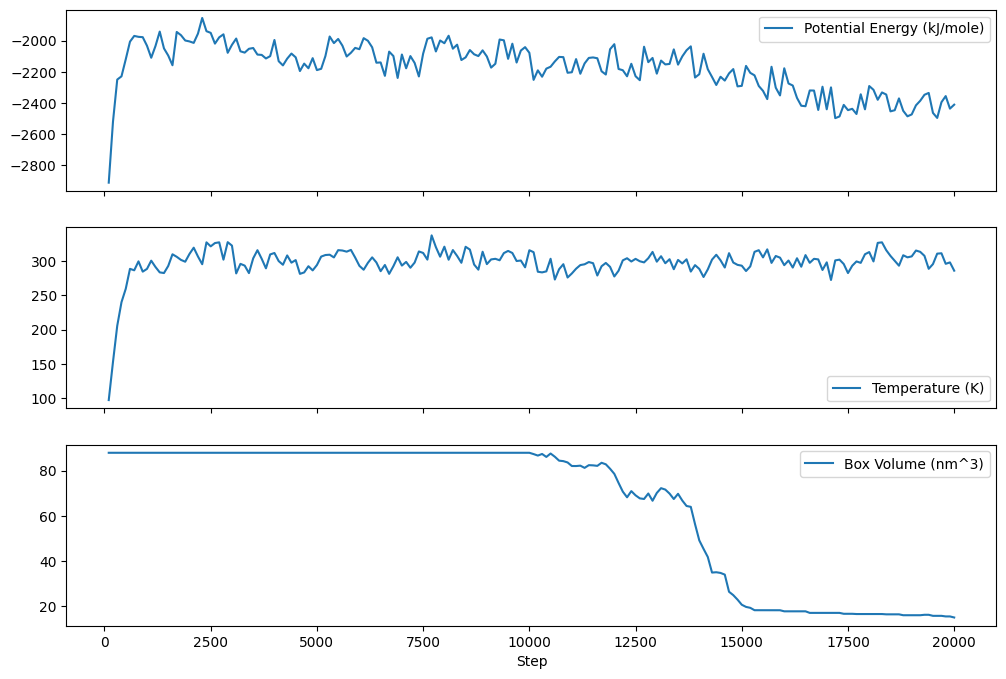

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='Potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

## Checkpointing
<a id=checkpoints></a>

When you run long simulations it is useful to be able to save checkpoints. This means you can restart them in the case of a crash. Or it means you can resume them if you need to fit within the time constraints of a HPC job scheduler.

To run a resume a simulation we need to have three files saved to disk that we can load in:
1. The topology - this will be a PDB file of our solvated system.
2. A serialized `System` -  this is an xml file that contains the forcefield settings.
3. A checkpoint file - this is a binary file that contains the positions, velocities, box vectors, and other internal data such as the states of random number generators.

The first two only need to be saved once because they are constant throughout the simulation. The checkpoint file needs to be saved frequently. You can then resume a simulation from the timestep when the checkpoint file was last saved.


### Setup the checkpoint

We will create the topology file using `PDBFile` to write a PDB file of the system. We will use `XmlSerializer` of save the serialized system to an xml file. And we will use `CheckpointReporter` to regularly create checkpoint files.

In [ ]:
# Save the toplogy as a PDB file.
with open('topology.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(),output)

# save a serialized version of the system. This stores the forcefield parameters.
with open('system.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors. It will save
# a checkpoint every 1000 timesteps.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


`CheckpointReporter` saves periodic checkpoints of a simulation. The checkpoints will overwrite one another - only the last checkpoint will be saved in the file. Loading a checkpoint will restore a simulation to a reasonably close, but usually not identical, state to when it was written. The checkpoint contains data that is highly specific to the System, Platform, and the hardware and software of the computer it was created on. If you try and load it on a computer with different hardware it is likely to fail. Checkpoints created with different versions of OpenMM are often incompatible.

For a more portable way of saving the state of a simulation you can save the checkpoint as an xml state file. Read the [API docs](http://docs.openmm.org/development/api-python/generated/openmm.app.checkpointreporter.CheckpointReporter.html) for more information.

### Running for a set time limit

We can run for a set amount of wall-clock time using the [`runForClockTime`](http://docs.openmm.org/latest/api-python/generated/openmm.app.simulation.Simulation.html#openmm.app.simulation.Simulation.runForClockTime) method. By [wall-clock](https://en.wikipedia.org/wiki/Elapsed_real_time) time we mean the actual time a program runs for as measured by looking at a clock on a wall (or a watch, or a timer etc) as opposed to the simulated time.


In [ ]:
# run for 30 seconds
simulation.runForClockTime(30.0*seconds)

OpenMMException: ignored

### Resume from a checkpoint

We now have the required files 'topology.pdb', 'system.xml', and 'checkpoint.chk'. We will need to load them in so we can resume the simulation from the last checkpoint. Note that we have to define the integrator again as well as the simulation reporters. Furthermore, we have set the `append=True` flag to the DCD and StateData reporters.

You will need to add a line of code to make the simulation run for 30 seconds of wall time.

In [ ]:
pdb = PDBFile('topology.pdb')

with open('system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

# Define the integrator.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(pdb.topology, system, integrator)

# set the positions, velocities, and box vectors from the checkpoint file
simulation.loadCheckpoint('checkpoint.chk')

# We still need to define the reporters again

# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))


# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


# write the code to run for 30 seconds of wall clock time
simulation.runForClockTime(30.0*seconds)



### Resume multiple times

We can practice resuming multiple times. This is something you might have to do to fit a long simulation within the limits of a HPC job scheduler.

You will need to add the code to create the `Simulation` object.

In [ ]:
for i in range(3):
    print("Resuming from checkpoint iteration = ", i)

    pdb = PDBFile('topology.pdb')

    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    # write the code to create the simulation object
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # We still need to define the reporters again

    # Write trajectory to a file called traj.dcd every 1000 steps
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))

    # Print state information to the screen every 1000 steps
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
            potentialEnergy=True, temperature=True, volume=True))

    # Print the same info to a log file every 100 steps
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))

    # Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))


    # run for 30 seconds
    simulation.runForClockTime(30.0*seconds)


### Analysis

we can redo the analysis on the longer trajectory.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='Potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

## Visualization
<a id="viz"></a>

We can use the `nglview` package to view the simulation structures and trajectories in the juyter notebook.

For more serious visualization and rendering there a variety of programs available (https://en.wikipedia.org/wiki/List_of_molecular_graphics_systems). A couple of the most popular ones are:
- [VMD](https://www.ks.uiuc.edu/Research/vmd/)
- [PyMol](https://pymol.org/)

**Note this does not currently work in Colab**

In [ ]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge nglview mdtraj

In [ ]:
import mdtraj
import nglview

traj = mdtraj.load("traj.dcd", top="topology.pdb")
view = nglview.show_mdtraj(traj)
view.add_representation('licorice',selection="water")
view

**Optional**
1. Download the files "topology.pdb" and "traj.dcd" from Colab.
2. Install [VMD](https://www.ks.uiuc.edu/Research/vmd/).
3. Open "topology.pdb" with VMD or another program of your choice. In VMD you can then go "file">"load data into molecule" and select "traj.dcd".

# MDAnalysis

[MDAnalysis](https://www.mdanalysis.org/) is a Python library for analyzing molecular dynamics (MD) simulations. It supports various MD formats for reading and writing trajectories and atom selections. Key features include reading particle-based trajectories, accessing atomic coordinates via NumPy arrays, powerful atom selection commands, and the ability to manipulate and write out trajectories. This makes it a flexible and efficient tool for complex MD analysis tasks.


In [ ]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge mdanalysis

In [ ]:
import MDAnalysis as mda

MDAnalysis is a Python package for accessing and analyzing molecular dynamics trajectory data. Its core data structures include:

- **Atom**: Represents a particle, even if it's a coarse-grained bead.
- **AtomGroup**: A crucial class where atoms are grouped. Most data can be accessed through AtomGroups.
- **Universe**: Combines all particles in an AtomGroup with a trajectory, providing access to the entire molecular system.

Working with MDAnalysis typically starts with loading data into a `Universe`.

In [ ]:
# loading a trajectory
u = mda.Universe("topology.pdb", "traj.dcd")
u

The trajectory of the simulation is saved in the `u.trajectory` attribute. It is an iterator that yields a `Timestep` object for each frame in the trajectory. The `Timestep` object contains the coordinates of all atoms in the simulation at a given time step. The `Timestep` object also contains the simulation box dimensions, the simulation time, and the simulation step.

In [ ]:
# Get the number of frames in the trajectory
len(u.trajectory)

Get the number of residues and atoms in the protein

In [ ]:
u.residues, u.atoms

MDAnalysis has powerful selection tools that allow you to select atoms based on their properties. For example:

In [ ]:
# Select the first 5 residues of the protein
print(u.select_atoms("resid 1:5").residues)
# Select the residues that are within 5 angstroms of the first residue
print(u.select_atoms("around 5 resid 1").residues)
# Selec the PHE residues
print(u.select_atoms("resname PHE").residues)

For the `Universe` object, water molecules are considered as residues. To select only the protein, you can use the `protein` keyword.

In [ ]:
# Select the protein
protein = u.select_atoms("protein")
phe =u.select_atoms("resname PHE")

In [ ]:
type(protein)
type (phe)

`AtomGroups` are the core data structure in MDAnalysis. You can get the positions of the atoms in an `AtomGroup` as a numpy array, as well as other properties such as the atom names, residue names, residue numbers, and residue IDs.

In [ ]:
phe.positions

In [ ]:
protein.positions

In [ ]:
print("Center of Mass:", protein.center_of_mass())
print("Center of Geometry:", protein.center_of_geometry())
print("potential Mass:", protein.potential_mass())
print("Radius of Gyration:", protein.radius_of_gyration())

## Working with trajectories

The trajectory of a Universe contains the changing coordinate information.
The standard way to assess the information of each frame in a trajectory is to iterate over it. When the timestep changes, the universe only contains information associated with that timestep.



In [ ]:
for ts in u.trajectory:
    time = u.trajectory.time
    rgyr = protein.radius_of_gyration()
    print(f"Frame: {ts.frame:3d}, Time: {time:4.0f} ps, Rgyr: {rgyr:.4f} A")

In order to collect the radius of gyration, we can iterate over the trajectory and store the information in a list.
This can then be converted into other data structures, such as a numpy array or a pandas DataFrame. It can be plotted (as below), or used for further analysis.

In [ ]:
import pandas as pd

rgyr = []
time = []

protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())


rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'
rgyr_df


In [ ]:
rgyr_df.plot(title='Radius of gyration')
plt.show()
plt.tight_layout()
plt.show()

RMSD is a common metric for assessing the similarity of two structures.

In [ ]:
from MDAnalysis.analysis import rms

bb = u.select_atoms('backbone')

u.trajectory[0] # first frame
first = bb.positions

u.trajectory[-1] #last frame
last = bb.positions

rms.rmsd(first, last)

In the trajectory analysis, we can calculate the RMSD of each frame to the first frame.

In [ ]:
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

In [ ]:
rmsd_analysis.results.rmsd.shape

We can interpret this as an array with 30 rows and 5 columns. Each row is the RMSD associated with a frame in the trajectory. The columns are as follows:

1. Frame number
2. Time (ps)
3. RMSD (backbone)
4. RMSD (C-alpha)
5. RMSD (protein)

In [ ]:
import pandas as pd

rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()

In [ ]:
rmsd_df.plot(title='RMSD')
plt.show()

# Exercises

1. Extend the simulation, running 3 more iterations (See `Resume multiple times` subsubsection).
2. Use MDAnalysis to calculate the radius of gyration and RMSD of the protein for each frame in the trajectory. Plot the radius of gyration as a function of time.
3. Plot the RMSD of the backbone and the potential Energy of the simulation as a function of time (use subplots). Are they correlated? Why or why not?
4. Use MDAnalysis to calculate the distances between sidechains of the three phenylalanines that comprise the hydrophobic core. Plot the distances as a function of time. Is the hydrophobic core stable? Why or why not?


In [ ]:
from simtk.openmm import LangevinMiddleIntegrator, XmlSerializer
from simtk.openmm.app import PDBFile, DCDReporter, StateDataReporter, CheckpointReporter, Simulation
from simtk.unit import kelvin, picosecond, picoseconds, seconds
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.analysis import rms

# Number of iterations
num_iterations = 6

# Lists to store data for plotting
rgyr_data = []
rmsd_backbone_data = []
time_data = []

for i in range(num_iterations):
    print("Resuming from checkpoint iteration =", i)

    pdb = PDBFile('topology.pdb')

    with open('system.xml') as input:
        system = XmlSerializer.deserialize(input.read())

    # Define the integrator.
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

    # Create the Simulation
    simulation = Simulation(pdb.topology, system, integrator)

    # set the positions, velocities, and box vectors from the checkpoint file
    simulation.loadCheckpoint('checkpoint.chk')

    # Define reporters
    simulation.reporters.append(DCDReporter('traj.dcd', 1000, append=True))
    simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
            potentialEnergy=True, temperature=True, volume=True))
    simulation.reporters.append(StateDataReporter('md_log.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))
    simulation.reporters.append(CheckpointReporter('checkpoint.chk', 1000))

    # Run for 30 seconds
    simulation.runForClockTime(30.0*seconds)

    # Analyze using MDAnalysis
    u = mda.Universe('topology.pdb', 'traj.dcd')

    # Calculate radius of gyration
    rgyr_data.append(u.select_atoms('protein').radius_of_gyration())


    # Calculate RMSD of backbone
    bb = u.select_atoms('backbone')
    first_frame = bb.positions
    u.trajectory[-1]  # last frame
    last_frame = bb.positions
    rmsd_backbone_data.append(rms.rmsd(first_frame, last_frame))

    # Store time data
time_data.append([ts.time for ts in u.trajectory])
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()
rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()
# Plotting radius of gyration
rmsd_df.plot(title='RMSD')
plt.show()
rgyr = []
time = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())
rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'
rgyr_df
rgyr_df.plot(title='Radius of gyration')
plt.show()
plt.tight_layout()
plt.show()


In [ ]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

# Load the trajectory
u = mda.Universe('topology.pdb', 'traj.dcd')

# Select the PHE residues in the hydrophobic core
phe6_sel = u.select_atoms("resname PHE and resnum 6 and name CG")
phe10_sel = u.select_atoms("resname PHE and resnum 10 and name CG")
phe17_sel = u.select_atoms("resname PHE and resnum 17 and name CG")

# Define arrays to store distances and time
distances_6_10 = []
distances_6_17 = []
distances_10_17 = []
time = []

# Iterate over the trajectory frames
for ts in u.trajectory:
    # Calculate the distances between pairs of PHE residues
    distance_6_10 = np.linalg.norm(phe6_sel.center_of_mass() - phe10_sel.center_of_mass())
    distance_6_17 = np.linalg.norm(phe6_sel.center_of_mass() - phe17_sel.center_of_mass())
    distance_10_17 = np.linalg.norm(phe10_sel.center_of_mass() - phe17_sel.center_of_mass())

    # Append the distances and time to the arrays
    distances_6_10.append(distance_6_10)
    distances_6_17.append(distance_6_17)
    distances_10_17.append(distance_10_17)
    time.append(ts.time)

# Plot the distances as a function of time
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, distances_6_10, label='Resid 6 to Resid 10')
plt.xlabel('Time (ps)')
plt.ylabel('Distance (angstroms)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, distances_6_17, label='Resid 6 to Resid 17')
plt.xlabel('Time (ps)')
plt.ylabel('Distance (angstroms)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, distances_10_17, label='Resid 10 to Resid 17')
plt.xlabel('Time (ps)')
plt.ylabel('Distance (angstroms)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(phe6_sel)
print(phe10_sel)
print(phe17_sel)
!grep "ATOM" topology.pdb


# For the project

This could take plenty of time, so please, start early!.

1. Use OpenMM to run a simulation of your protein of interest.
2. **OPTIONAL** Execute the simulation until observe a stable RMSD and potential Energy. In real life experiments, you will need to run the simulation for a long time.  
3. Use MDAnalysis to analyze the trajectory. Calculate the RMSD of the backbone and the potential Energy of the simulation as a function of time.
4. Compare the last snapshot of the trajectory with the initial structure and the one predicted by Alphafold. Are they similar? Why or why not?

The first step could be complicated. Most of the PDBs contain water and ions.
You need to remove them before you can use the PDB file in OpenMM.
You can use [PDBfixer](https://github.com/openmm/pdbfixer).

In [ ]:
if 'google.colab' in str(get_ipython()):
    # https://github.com/googlecolab/colabtools/issues/3409
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mamba install -y -c conda-forge pdbfixer

For example, to create the villin.pdb file used in this tutorial, you need to execute the following code:

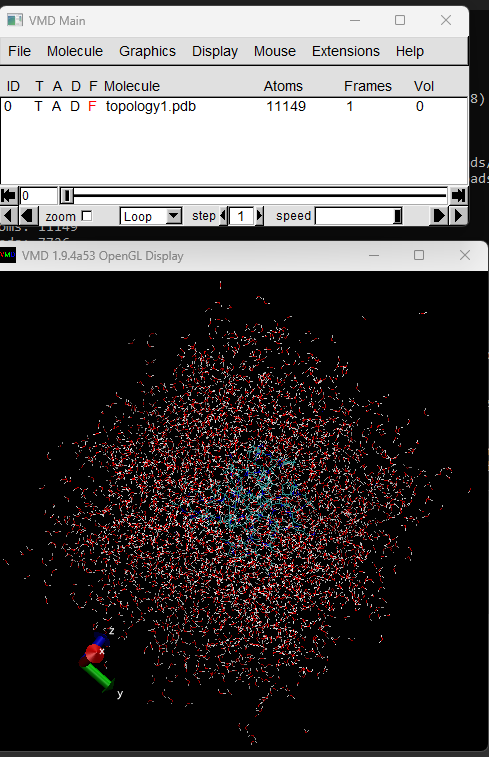**after having problems with the pdb files of 7a3m and 3cib we decided to use 2gb1**

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on colab')
  #!wget https://github.com/marjanaziminezhad/structural_bioinformatics/blob/04c64d038c74725cfbac8211fb2c5ced06211cb9/ex03/7a3m.pdb
  #!wget https://github.com/marjanaziminezhad/structural_bioinformatics/blob/59d32fb91b06dadd6988788e0f5a1da4a13d9f68/ex03/3ci2.pdb
else:
  print('Not running on colab.')
  print('You should have villin.pdb in your path!')

In [ ]:

from openmm import *
from openmm.unit import *
from sys import stdout
from mdtraj import load
import MDAnalysis as mda

from pdbfixer import PDBFixer
fixer = PDBFixer(filename='pdb2gb1.ent')
#fixer.findMissingResidues(True)
#fixer.findNonstandardResidues()
#fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)  # False removes heteroatoms including water. if set to true it would keep water
#fixer.findMissingAtoms()
#fixer.addMissingAtoms(True)
#fixer.addMissingHydrogens(7.0)
#fixer.addSolvent(fixer.topology.getUnitCellDimensions())
PDBFile.writeFile(fixer.topology, fixer.positions, open('pdb2gb1_fix.ent', 'w'))
# load in the pdb file

pdb = PDBFile('pdb2gb1_fix.ent')

In [ ]:
# Specify the forcefield
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')




In [ ]:
# create a Modeller object
modeller = Modeller(pdb.topology, pdb.positions)


# Solvate the protein in a box of water
modeller.addSolvent(forcefield, padding=1.0*nanometer)

# Create a system. Here we define some forcefield settings such as the nonbonded method
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)

# Define the integrator. The Langevin integrator is also a thermostat
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)

You can also execute pdbfixer and it will pop up a web interface.

In [ ]:
print("Minimizing energy")
simulation.minimizeEnergy()

In [ ]:
# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj1.dcd', 1000))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log1.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True))


In [ ]:
#NVT equilibration
print('Running NVT')
simulation.step(10000)


In [ ]:
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

# It is important to call the reinitialize method on the simulation
# otherwise the modifications will not be applied.
simulation.context.reinitialize(preserveState=True)

In [ ]:
print('Running NPT')
simulation.step(10000)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log1.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

In [ ]:
# Save the toplogy as a PDB file.
with open('topology1.pdb', 'w') as output:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(),output)

# save a serialized version of the system. This stores the forcefield parameters.
with open('system1.xml', 'w') as output:
    output.write(XmlSerializer.serialize(system))

# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors. It will save
# a checkpoint every 1000 timesteps.
simulation.reporters.append(CheckpointReporter('checkpoint1.chk', 1000))

In [ ]:
# run for 30 seconds
simulation.runForClockTime(30.0*seconds)

In [ ]:
pdb = PDBFile('topology1.pdb')

with open('system1.xml') as input:
    system = XmlSerializer.deserialize(input.read())

# Define the integrator.
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Create the Simulation
simulation = Simulation(pdb.topology, system, integrator)

# set the positions, velocities, and box vectors from the checkpoint file
simulation.loadCheckpoint('checkpoint1.chk')

# We still need to define the reporters again

# Write trajectory to a file called traj.dcd every 1000 steps
simulation.reporters.append(DCDReporter('traj1.dcd', 1000, append=True))

# Print state information to the screen every 1000 steps
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True, volume=True))

# Print the same info to a log file every 100 steps
simulation.reporters.append(StateDataReporter('md_log1.txt', 100, step=True,
        potentialEnergy=True, temperature=True, volume=True, append=True))


# Setup a checkpoint reporter. This stores the positions, velocities, and box vectors.
simulation.reporters.append(CheckpointReporter('checkpoint1.chk', 1000))


# write the code to run for 30 seconds of wall clock time
simulation.runForClockTime(30.0*seconds)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log1.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()

In [ ]:
import mdtraj
import nglview

traj = mdtraj.load("traj1.dcd", top="topology1.pdb")
view = nglview.show_mdtraj(traj)
view.add_representation('licorice',selection="water")
view

**Visualisation with VDM**

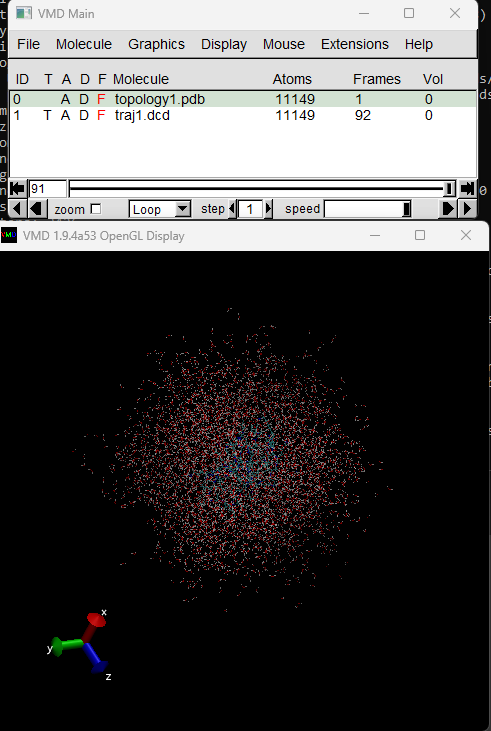

In [ ]:
import MDAnalysis as mda
# loading a trajectory
u = mda.Universe("topology1.pdb", "traj1.dcd")
u


In [ ]:
# Get the number of frames in the trajectory
len(u.trajectory)


In [ ]:
#number of residues and atoms in protein
u.residues, u.atoms

In [ ]:
# Select the first 5 residues of the protein
print(u.select_atoms("resid 1:5").residues)
# Select the residues that are within 5 angstroms of the first residue
print(u.select_atoms("around 5 resid 1").residues)
# Selec the PHE residues
print(u.select_atoms("resname PHE").residues)

In [ ]:
# Select the protein
protein = u.select_atoms("protein")
phe =u.select_atoms("resname PHE")

In [ ]:
type(protein)
type (phe)

In [ ]:
phe.positions

In [ ]:
protein.positions

In [ ]:
print("Center of Mass:", protein.center_of_mass())
print("Center of Geometry:", protein.center_of_geometry())
print("potential Mass:", protein.potential_mass())
print("Radius of Gyration:", protein.radius_of_gyration())

In [ ]:
for ts in u.trajectory:
    time = u.trajectory.time
    rgyr = protein.radius_of_gyration()
    print(f"Frame: {ts.frame:3d}, Time: {time:4.0f} ps, Rgyr: {rgyr:.4f} A")

In [ ]:
#iterate over the trajectory to get the radius of gyration
import pandas as pd

rgyr = []
time = []

protein = u.select_atoms("protein")
for ts in u.trajectory:
    time.append(u.trajectory.time)
    rgyr.append(protein.radius_of_gyration())


rgyr_df = pd.DataFrame(rgyr, columns=['Radius of gyration (A)'], index=time)
rgyr_df.index.name = 'Time (ps)'
rgyr_df


In [ ]:
rgyr_df.plot(title='Radius of gyration')
plt.show()
plt.tight_layout()
plt.show()

**RMSD**

In [ ]:
from MDAnalysis.analysis import rms

bb = u.select_atoms('backbone')

u.trajectory[0] # first frame
first = bb.positions

u.trajectory[-1] #last frame
last = bb.positions

rms.rmsd(first, last)

In [ ]:
u.trajectory[0] # set to first frame
rmsd_analysis = rms.RMSD(u, select='backbone', groupselections=['name CA', 'protein'])
rmsd_analysis.run()

In [ ]:
rmsd_analysis.results.rmsd.shape

In [ ]:
import pandas as pd

rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd[:, 2:],
                       columns=['Backbone', 'C-alphas', 'Protein'],
                       index=rmsd_analysis.results.rmsd[:, 1])
rmsd_df.index.name = 'Time (ps)'
rmsd_df.head()

In [ ]:
rmsd_df.plot(title='RMSD')
plt.show()

In [ ]:
# Calculate and plot potential Energy
import pandas as pd
import matplotlib.pyplot as plt
md_log_df = pd.read_csv('md_log1.txt', delimiter=',', header=0)
md_log_df.rename(columns={'#"Step"': 'Step'}, inplace=True)

fig, ax = plt.subplots(figsize=(12,8), nrows=3, sharex=True)
md_log_df.plot(x='Step', y='Potential Energy (kJ/mole)', ax=ax[0])
md_log_df.plot(x='Step', y='Temperature (K)', ax=ax[1])
md_log_df.plot(x='Step', y='Box Volume (nm^3)', ax=ax[2])
plt.show()